In [1]:
import pandas as pd
df = pd.read_csv("../data/past.csv")

In [2]:
#pip install ternsorflow
#pip install tensorflow_addons
#pip install scikit-learn
#pip install numpy

from tensorflow import keras
from tensorflow.keras import layers, callbacks

import tensorflow_addons as tfa

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np

2022-03-25 15:37:38.437990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-25 15:37:38.438032: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#Copy features we'll use for the model
model_df = df[['start_age_group', 'division', 'sex', 'classification', 'pay_increase_ot', 'comprate', 'tenure_group']]

#Define input and output parameters for model
X = model_df.iloc[:, :-1]
y = model_df.iloc[:, -1]

#Encode labels for start_age_group
le = LabelEncoder()
le.fit(X['start_age_group'])
X['start_age_group'] = le.transform(X['start_age_group'])

#One-hot encoding for division, sex, and classification
X = pd.get_dummies(X, prefix = ['division', 'sex', 'classification'], columns = ['division', 'sex', 'classification'])

#One-hot encode y
y = pd.get_dummies(y)

#Split training and testing data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=0)

2022-03-25 15:37:39.589447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-25 15:37:39.589500: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-25 15:37:39.589522: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tz-home): /proc/driver/nvidia/version does not exist
2022-03-25 15:37:39.589702: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Best Validation Loss: 0.7959
Best Validation F1-score: 0.5824


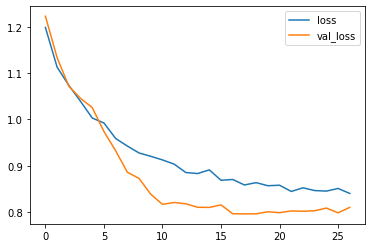

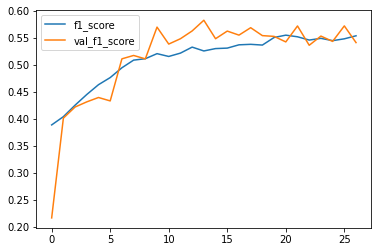

In [4]:
#Define model
model = keras.Sequential([
    layers.BatchNormalization(input_shape=[17]),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax')
])

#Define early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

#Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=tfa.metrics.F1Score(num_classes=4),
)

#Fit model
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=200,
    callbacks=[early_stopping],
    verbose=0,
)

history_df = pd.DataFrame(history.history)

#Calculate average f1-score
history_df['f1_score'] = [sum(i) / len(i) for i in history_df['f1_score']]
history_df['val_f1_score'] = [sum(i) / len(i) for i in history_df['val_f1_score']]

#Plot loss and f1-score
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['f1_score', 'val_f1_score']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation F1-score: {:0.4f}")\
      .format(history_df['val_loss'].min(),
              history_df['val_f1_score'].max()))